In [1]:
from keras.layers import Dense,Dropout,Input,MaxPooling2D,ZeroPadding2D,Conv2D,Flatten
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.utils import to_categorical

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

pn.options.display.max_colwidth=150

Using TensorFlow backend.
C:\Users\win10\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\win10\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\win10\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\win10\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#read from labels.csv all the dog breeds
df2=pn.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
df2.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
# path of the dogs images
image_file='C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/'

In [4]:
df1=df2.assign(img_path=lambda x: image_file + x['id'] +'.jpg') #data framework images from the training folder
df1.head() #first 5 elemes from the data framework

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [5]:
#Number of different breed type
df1.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

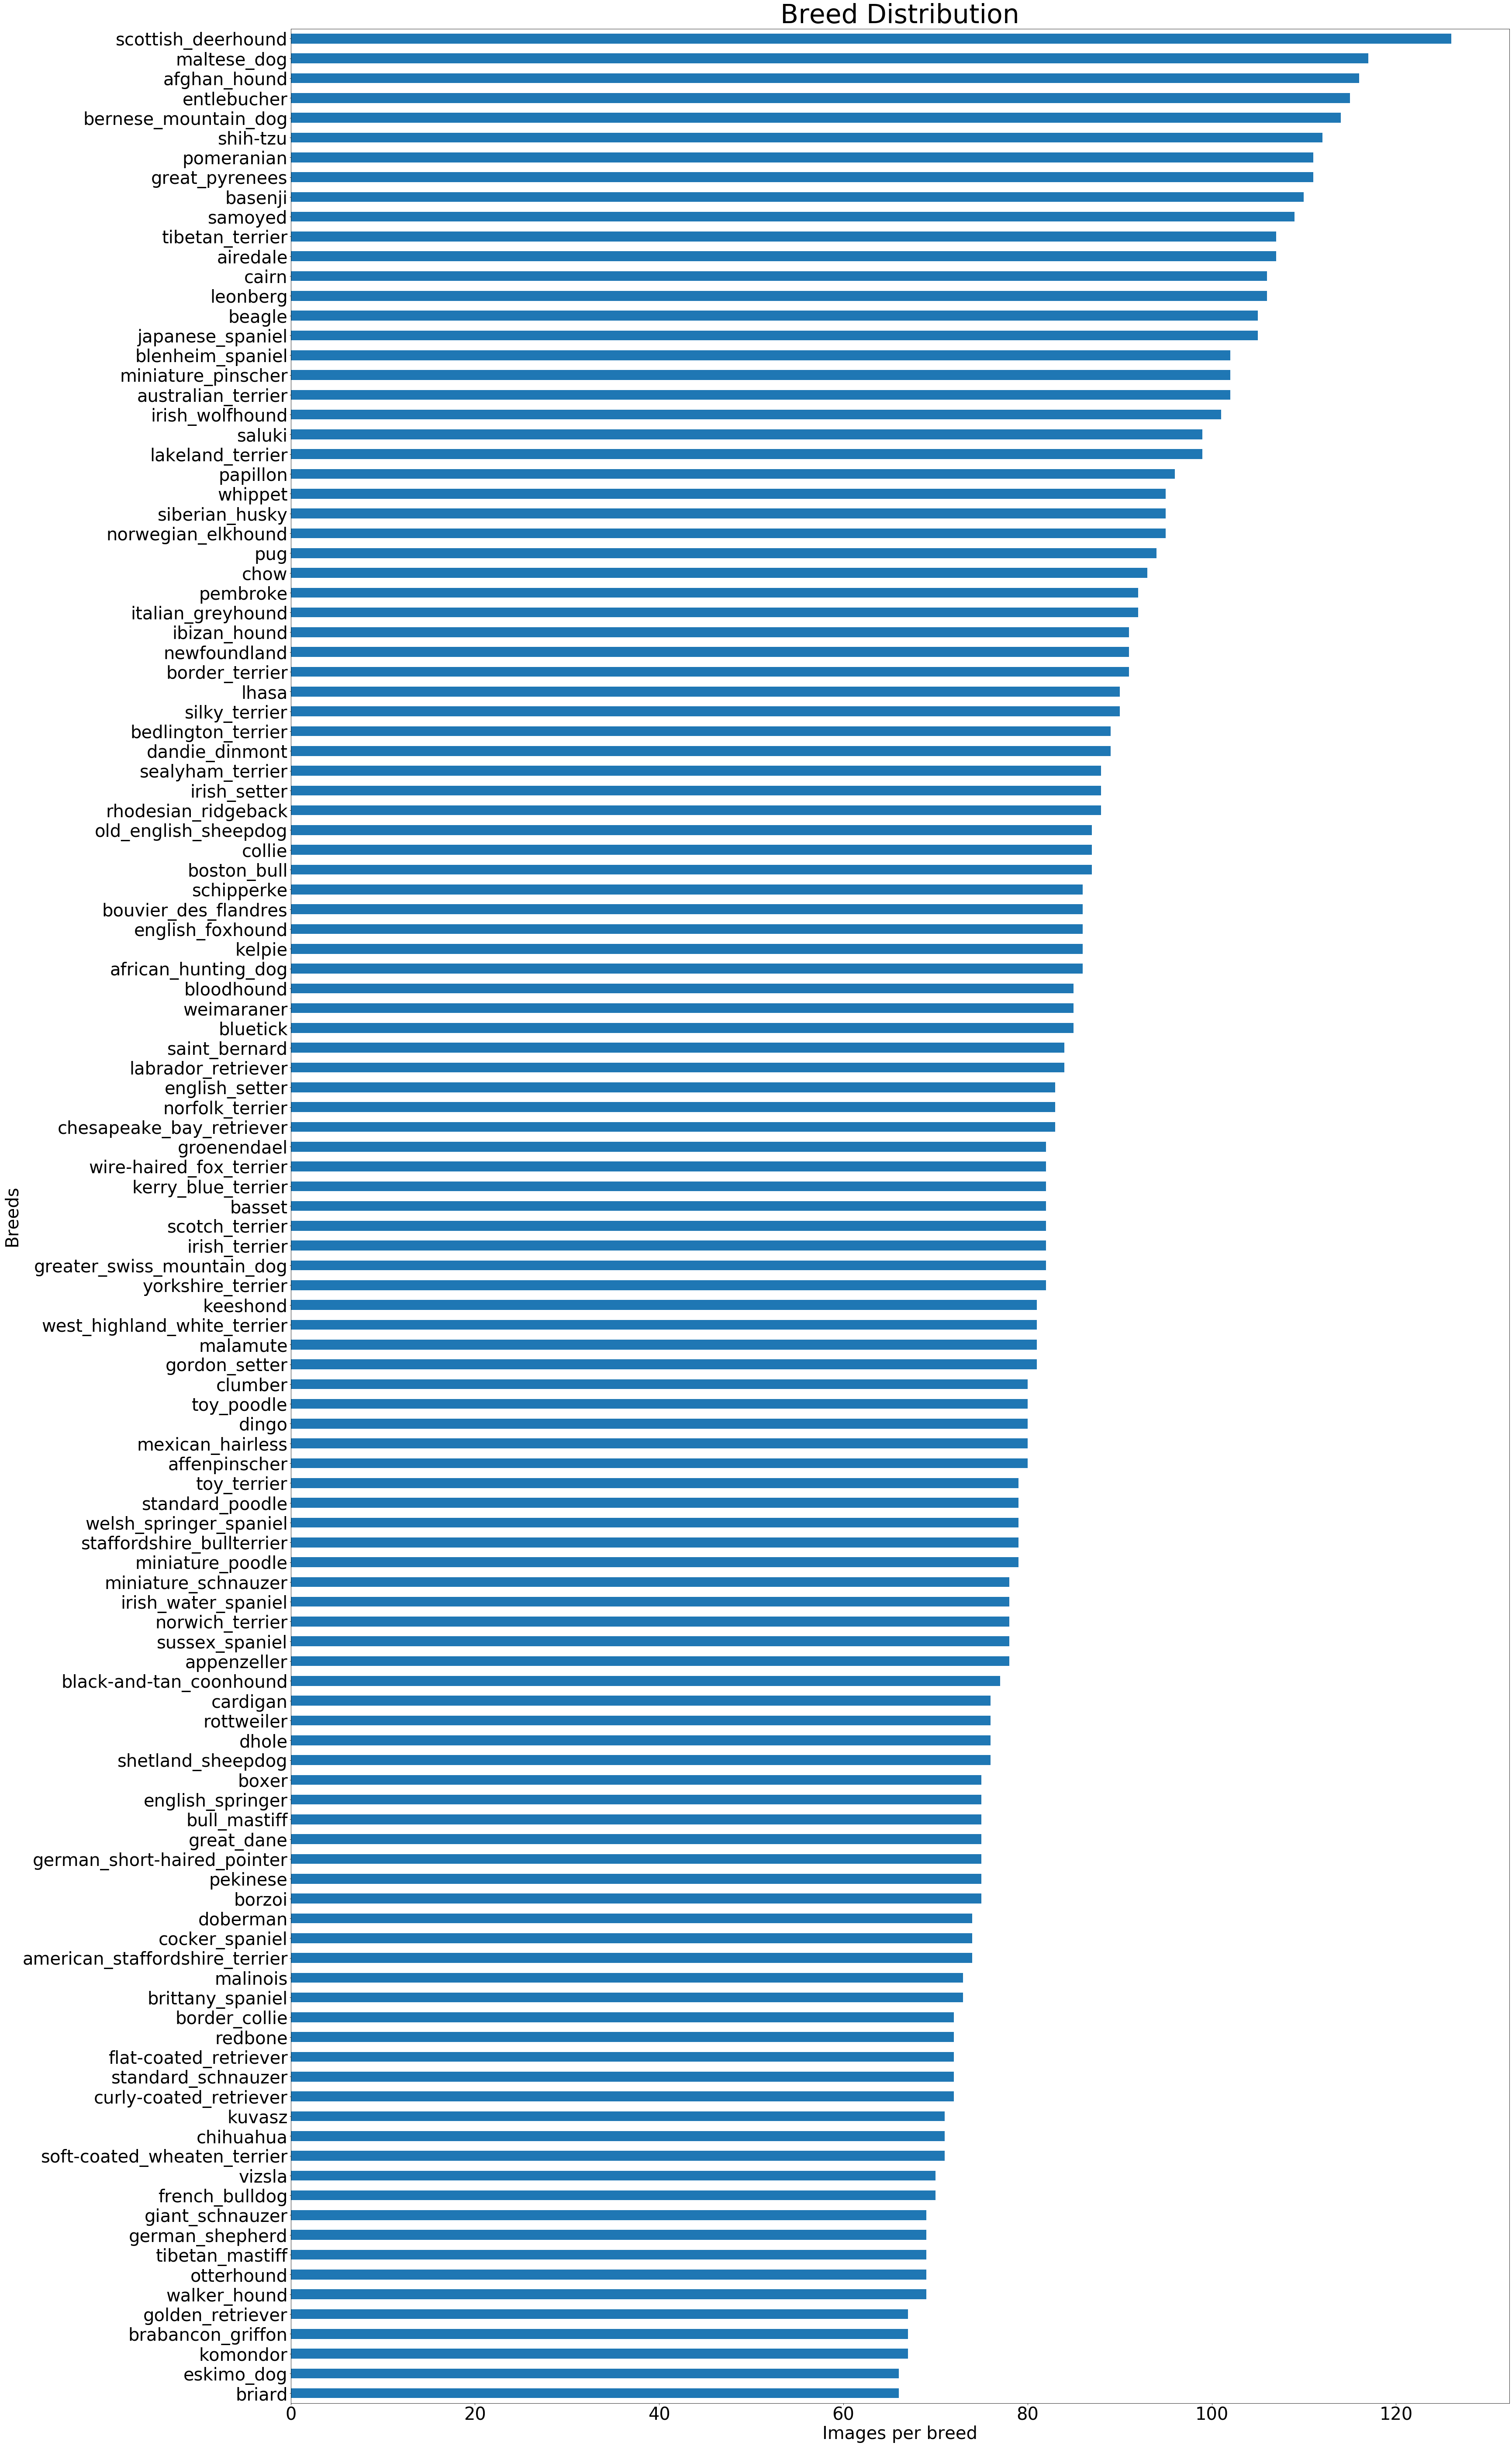

In [6]:
# Take a look at the class/breed distribution
ax=pn.value_counts(df1['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Breed Distribution",figsize=(50,100))
ax.set(xlabel="Images per breed", ylabel="Breeds")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [6]:
#Top 20 breed in descending order
top_20=list(df1.breed.value_counts()[0:20].index)
top_20

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'pomeranian',
 'great_pyrenees',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'cairn',
 'leonberg',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'miniature_pinscher',
 'blenheim_spaniel',
 'irish_wolfhound']

In [7]:
df3=df1[df1.breed.isin(top_20)]
df3.shape

(2184, 3)

In [8]:
#loading images and converting it to pixel
#for machine learning operation, we are loading the images and converting it to numpy array of pixel
img_pixel=np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in df3['img_path'].values.tolist()])
img_pixel.shape

(2184, 299, 299, 3)

100%|████████████████████████████████████████████████████████████████████████████| 10222/10222 [02:02<00:00, 83.16it/s]


Images to show: 9
Classes to show: 9


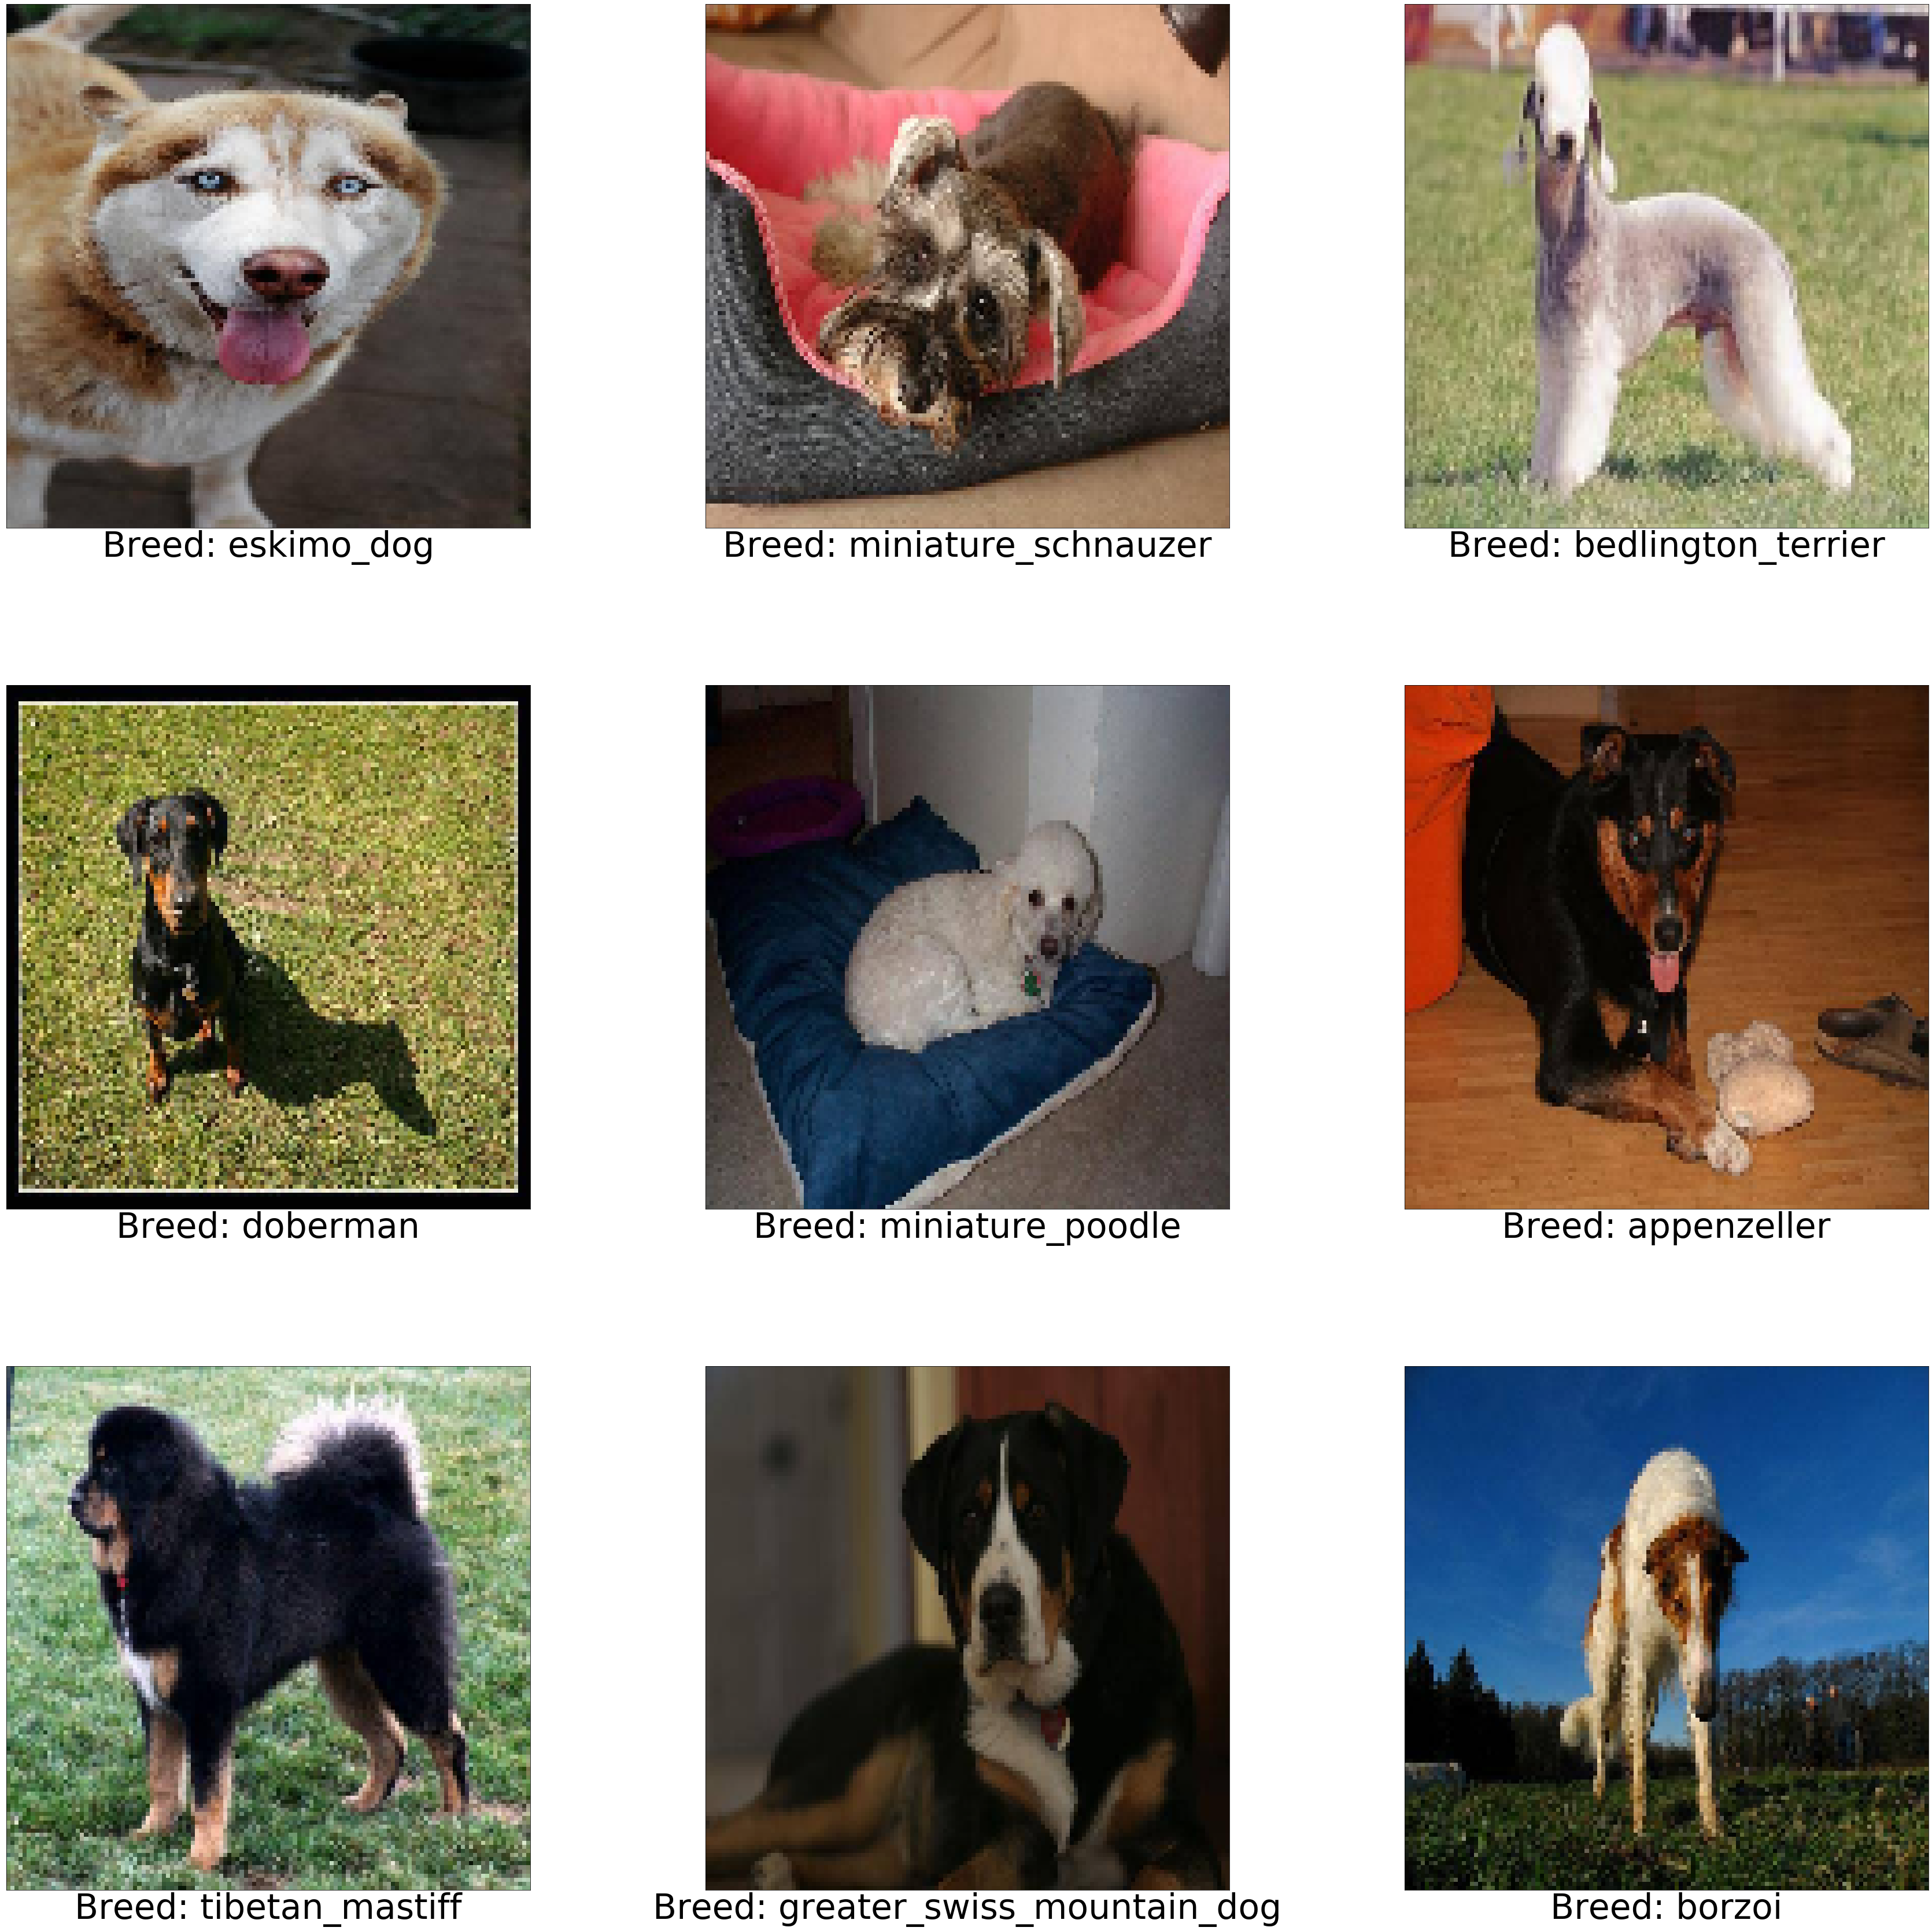

In [10]:
#loading the CSV File with pandas
labels = pn.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
submission = pn.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/sample_submission.csv')
# checking is there any missing value
labels.isnull().values.any()
# check first 10 rows of data
labels.head(10)

from tqdm import tqdm
import cv2
# Helper-function for plotting images
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    
    plt.show()

# I have also set an im_width variable which sets the size for the image to be re-sized to, 128x128 px
img_width = 128
img_height = 128
images = []
classes = []
# load training images
for f, breed in tqdm(labels.values):
    img = cv2.imread('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/train/{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width, img_height)))
# plot some example images
# select random images
from random import randint
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))
# plot the images
plot_images(images_to_show, classes_to_show)

In [9]:
#5. Label encoding Dogs breed name for prediction
img_label=df3.breed
img_label=pn.get_dummies(df3.breed) #Convert Series to dummy codes.-frequences matrix on columns
img_label.head() #first 5 elems

,afghan_hound,airedale,australian_terrier,basenji,beagle,bernese_mountain_dog,blenheim_spaniel,cairn,entlebucher,great_pyrenees,irish_wolfhound,japanese_spaniel,leonberg,maltese_dog,miniature_pinscher,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
#Final X,y Matrix for Deep learning prediction
X=img_pixel     #pizels of all images
y=img_label.values #classes of dogs
print(X.shape) 
print(y.shape)

(2184, 299, 299, 3)
(2184, 20)


In [11]:
# Train test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1747, 299, 299, 3)
(1747, 20)
(437, 299, 299, 3)
(437, 20)


In [12]:
#8. Data pre-processing and data augmentation
#Image generator, to generate rotated,shifted,flipped images etc. To over come Translational invariance
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=32)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=32)

In [16]:
model=Sequential()

model.add(ZeroPadding2D((1,1),input_shape=(299,299,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(64,input_shape=(299,299,3),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(20,input_shape=(299,299,3),activation='softmax'))

model.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()
#print(model.predict(training_set))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 301, 301, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      896       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 301, 301, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 710432)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)              

In [17]:
history=model.fit_generator(training_set,
                      steps_per_epoch = 255,
                      validation_data = testing_set,
                      validation_steps = 4,
                      epochs = 529,
                      verbose = 1)


Epoch 1/529
255/255 [==============================] - 3019s 12s/step - loss: 3.5011 - accuracy: 0.0673 - val_loss: 2.9641 - val_accuracy: 0.0703
Epoch 2/529
255/255 [==============================] - 2703s 11s/step - loss: 2.9467 - accuracy: 0.0913 - val_loss: 2.9736 - val_accuracy: 0.0781
Epoch 3/529
255/255 [==============================] - 2703s 11s/step - loss: 2.8924 - accuracy: 0.1050 - val_loss: 3.0154 - val_accuracy: 0.1484
Epoch 4/529
255/255 [==============================] - 2700s 11s/step - loss: 2.8541 - accuracy: 0.1262 - val_loss: 2.8909 - val_accuracy: 0.1282
Epoch 5/529
255/255 [==============================] - 2723s 11s/step - loss: 2.7964 - accuracy: 0.1359 - val_loss: 2.7869 - val_accuracy: 0.1406
Epoch 6/529
255/255 [==============================] - 2707s 11s/step - loss: 2.7358 - accuracy: 0.1505 - val_loss: 2.7969 - val_accuracy: 0.1797
Epoch 7/529
255/255 [==============================] - 2700s 11s/step - loss: 2.6978 - accuracy: 0.1663 - val_loss: 2.8323 

Epoch 111/529
255/255 [==============================] - 2706s 11s/step - loss: 1.4188 - accuracy: 0.5303 - val_loss: 4.5409 - val_accuracy: 0.1797
Epoch 112/529
255/255 [==============================] - 2708s 11s/step - loss: 1.4242 - accuracy: 0.5273 - val_loss: 3.0848 - val_accuracy: 0.2821
Epoch 113/529
255/255 [==============================] - 2707s 11s/step - loss: 1.4148 - accuracy: 0.5318 - val_loss: 2.8551 - val_accuracy: 0.3047
Epoch 114/529
255/255 [==============================] - 2709s 11s/step - loss: 1.4315 - accuracy: 0.5297 - val_loss: 3.3277 - val_accuracy: 0.2266
Epoch 115/529
255/255 [==============================] - 2707s 11s/step - loss: 1.4060 - accuracy: 0.5353 - val_loss: 5.3672 - val_accuracy: 0.2188
Epoch 116/529
255/255 [==============================] - 2705s 11s/step - loss: 1.4036 - accuracy: 0.5384 - val_loss: 3.7436 - val_accuracy: 0.2650
Epoch 117/529
255/255 [==============================] - 2704s 11s/step - loss: 1.3864 - accuracy: 0.5427 - val_

255/255 [==============================] - 2714s 11s/step - loss: 1.2507 - accuracy: 0.5865 - val_loss: 3.9341 - val_accuracy: 0.2906
Epoch 222/529
255/255 [==============================] - 2727s 11s/step - loss: 1.2481 - accuracy: 0.5879 - val_loss: 3.6186 - val_accuracy: 0.2578
Epoch 223/529
255/255 [==============================] - 2716s 11s/step - loss: 1.2457 - accuracy: 0.5925 - val_loss: 3.7731 - val_accuracy: 0.3047
Epoch 224/529
255/255 [==============================] - 2728s 11s/step - loss: 1.2504 - accuracy: 0.5861 - val_loss: 5.2367 - val_accuracy: 0.2393
Epoch 225/529
255/255 [==============================] - 2722s 11s/step - loss: 1.2457 - accuracy: 0.5909 - val_loss: 5.1802 - val_accuracy: 0.2578
Epoch 226/529
255/255 [==============================] - 2733s 11s/step - loss: 1.2521 - accuracy: 0.5871 - val_loss: 5.2810 - val_accuracy: 0.3203
Epoch 227/529
255/255 [==============================] - 2730s 11s/step - loss: 1.2354 - accuracy: 0.5879 - val_loss: 3.7198 -

255/255 [==============================] - 2735s 11s/step - loss: 1.1703 - accuracy: 0.6058 - val_loss: 4.2483 - val_accuracy: 0.2500
Epoch 332/529
255/255 [==============================] - 2738s 11s/step - loss: 1.1457 - accuracy: 0.6157 - val_loss: 4.2606 - val_accuracy: 0.1875
Epoch 333/529
255/255 [==============================] - 2731s 11s/step - loss: 1.1600 - accuracy: 0.6170 - val_loss: 6.1286 - val_accuracy: 0.2991
Epoch 334/529
255/255 [==============================] - 2740s 11s/step - loss: 1.1467 - accuracy: 0.6250 - val_loss: 5.2369 - val_accuracy: 0.2656
Epoch 335/529
255/255 [==============================] - 2744s 11s/step - loss: 1.1774 - accuracy: 0.6104 - val_loss: 3.0344 - val_accuracy: 0.2891
Epoch 336/529
255/255 [==============================] - 2731s 11s/step - loss: 1.1659 - accuracy: 0.6147 - val_loss: 3.7843 - val_accuracy: 0.3761
Epoch 337/529
255/255 [==============================] - 2738s 11s/step - loss: 1.1704 - accuracy: 0.6131 - val_loss: 4.4861 -

255/255 [==============================] - 2743s 11s/step - loss: 1.1107 - accuracy: 0.6343 - val_loss: 6.0530 - val_accuracy: 0.2479
Epoch 442/529
255/255 [==============================] - 2764s 11s/step - loss: 1.1440 - accuracy: 0.6204 - val_loss: 3.7078 - val_accuracy: 0.3047
Epoch 443/529
255/255 [==============================] - 2747s 11s/step - loss: 1.1072 - accuracy: 0.6331 - val_loss: 4.0189 - val_accuracy: 0.2344
Epoch 444/529
255/255 [==============================] - 2760s 11s/step - loss: 1.1105 - accuracy: 0.6365 - val_loss: 3.4911 - val_accuracy: 0.2422
Epoch 445/529
255/255 [==============================] - 2745s 11s/step - loss: 1.1067 - accuracy: 0.6359 - val_loss: 3.1580 - val_accuracy: 0.2650
Epoch 446/529
255/255 [==============================] - 2760s 11s/step - loss: 1.0950 - accuracy: 0.6368 - val_loss: 4.5033 - val_accuracy: 0.3203
Epoch 447/529
255/255 [==============================] - 2756s 11s/step - loss: 1.1618 - accuracy: 0.6268 - val_loss: 3.1288 -

In [18]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

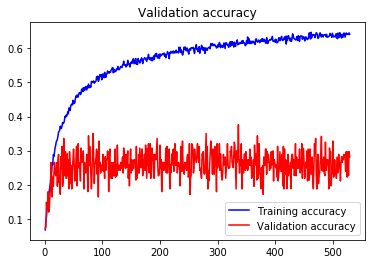

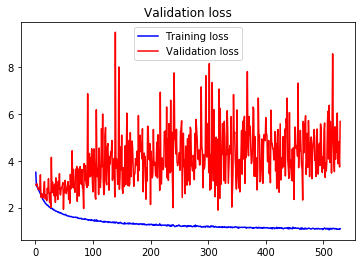

In [19]:
#lets plot the train and test curve
#get the details form the history object
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')

plt.title('Training accuracy')
plt.title('Validation accuracy')
plt.legend()

plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')

plt.title('Training loss')
plt.title('Validation loss')
plt.legend()

plt.show()


In [20]:
# i = 0
# test_labels = []
# plt.figure(figsize=(30,20))
# columns = 5
# x = np.array(X_test)
# img_pixel=np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in df3['img_path'].values.tolist()])
# for batch in test_datagen.flow(x, batch_size=1):
#     pred = model.predict(batch)
#     #if (pred-0.5).any():
#     test_labels.append('noOne')
#     plt.subplot(5/columns + 1, columns, i+1)
#     plt.title('This is ' + test_labels[i])
#     imgplot = plt.imshow(batch[0])
#     i+=1
#     if i % 10 == 0:
#         break
# plt.show

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
437/437 [==============================] - 54s 123ms/step
test loss, test acc: [12318.999032376287, 0.06636155396699905]

# Generate predictions for 3 samples
predictions shape: (3, 20)


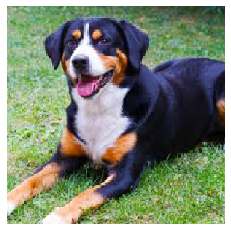

entlebucher
0.98630434


In [52]:
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

model = load_model('model_keras.h5')
input_shape=(299,299,3)
num_classes = 20 

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

img_path = 'C:/Users/win10/Documents/pati/Licenta/WebApplication/uploads/entlebutcher.jpg'
img = image.load_img(img_path, target_size=input_shape)
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(predicted_class)
print(max(pred)[sorted_breeds_list.index(predicted_class)])

# return predicted_class, max(pred)

In [58]:
#Evaluating the Test Set
from keras.models import load_model
import math
from sklearn.preprocessing import OneHotEncoder
model = load_model('model_keras.h5')
predictions = model.predict_generator(training_set)
# enc=OneHotEncoder(handle_unknown='ignore')
# X = [['scottish_deerhound',1],
#  ['maltese_dog',2],
#  ['afghan_hound',3],
#  ['entlebucher',4],
#  ['bernese_mountain_dog',5],
#  ['shih-tzu',6],
#  ['pomeranian',7],
#  ['great_pyrenees',8],
#  ['basenji',9],
#  ['samoyed',10],
#  ['airedale',11],
#  ['tibetan_terrier',12],
#  ['cairn',13],
#  ['leonberg',14],
#  ['beagle',15],
#  ['japanese_spaniel',16],
#  ['australian_terrier',17],
#  ['miniature_pinscher',18],
#  ['blenheim_spaniel',19],
#  ['irish_wolfhound',20]]
# enc.fit(X)

print(predictions)

[[4.8769586e-02 7.6536917e-06 1.1170396e-04 ... 7.9587674e-01
  1.7690442e-03 3.7994221e-02]
 [3.6103406e-03 3.0228967e-04 6.5116560e-06 ... 1.3122581e-01
  3.9978363e-03 1.2057388e-02]
 [2.5691387e-01 6.4305209e-02 1.3407390e-07 ... 1.1887515e-03
  8.4331841e-06 1.4204844e-06]
 ...
 [6.1905295e-05 2.8657316e-05 2.7704422e-04 ... 5.7959642e-02
  1.2317733e-01 7.4428970e-01]
 [4.2506330e-02 5.9988193e-02 1.3667072e-01 ... 8.8113593e-03
  2.9177865e-01 2.8511715e-01]
 [6.2882970e-04 2.9966654e-10 7.6587947e-10 ... 9.9265301e-01
  4.4538362e-07 2.3255163e-08]]


In [59]:
#Confusion matrix for multiclass classification
from sklearn.metrics import confusion_matrix
print(np.argmax(y_train,axis=1))
print(np.argmax(predictions,axis=1))
confusion = confusion_matrix(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1))
print('Confusion Matrix\n')
print(confusion)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy {:.2f}\n'.format(accuracy_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
top_20=['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'pomeranian',
 'great_pyrenees',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'cairn',
 'leonberg',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'miniature_pinscher',
 'blenheim_spaniel',
 'irish_wolfhound']
print(classification_report(np.argmax(y_train,axis=1),np.argmax(predictions,axis=1), target_names=top_20))

[17  9 12 ... 16 12  6]
[17  5 10 ... 19 18 17]
Confusion Matrix

[[ 6  3  2  3  4  5  2  7  7  5  3  4  6  6  7  3  3  9  2  8]
 [ 4  7  3  5  7  4  2  5  4  4  2  5  3  6  3  4  5  5  6  2]
 [ 4  2  3  7  7  6  4  6  8  7  3  4  1  2  3  3  1  8  1  7]
 [ 4  3  4  5  4  2  4  7  3  4  4  3  8  3  6  4  5  3  4  6]
 [ 2  4  3  5  6  6  3  5  5  3  7  4  1  2  5  6  5  5  5  3]
 [ 5  7  6  6  3  7  3  3  5  4  3  6  5  3  6  3  2  5  0  7]
 [ 4  5  2  6  5  4  5  2  4  4  3  2  4  3  3  2  3  5  9  4]
 [ 2  4  5  3  3  5  4  3 10  5  4  4  5  2  4  9  3  5  4  2]
 [ 1  3  7  4  3 11  6  2  6  7  5  4  3  6  2  4  6  9  3  3]
 [ 2  5  5  2  3  6  2  3  6  4  1  2  6  7  2  9  4  2  6  3]
 [ 6  7  3  1  3  5  4  2  4  5  4  3  4  6  3  3  6  5  3  2]
 [ 5  5  1  5  9  4  1  6  6  3  2  3  6  1  1  7  3  3  3  4]
 [ 6  4  4  4  1  3  5  3  5  0  5  3  4  3  5  5  6  7  5  6]
 [ 3  3  4  6  5  5  4  3  3  5  2  3  5  3  3  2  4 10  9  7]
 [ 4  2  5  2  6  9  2  5  3  2  2  4  6  3  5  2  2

In [60]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt

"""
Prints and plots the confusion matrix. Normalization can be applied by settings 'normalize=True'
"""
def confusion_matrix_normalization(cm,normalize=False):
    if normalize:
        cm=cm.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    cm=np.around(cm,decimals=3)

    leftmargin = 0.7#inches
    rightmargin = 0.7#inches
    categorysize = 0.7#inches
    figwidth = leftmargin + rightmargin + (len(top_20) * categorysize)
    #print(figwidth)

    f = plt.figure(figsize=(figwidth, figwidth))
    ax = f.add_subplot(111)
    ax.set_aspect(1)
    f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=1.5, bottom=1)
    res=ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)

    # plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Dog Identification')
    plt.colorbar(res)
    ax.set_xticks(range(len(top_20)))
    ax.set_yticks(range(len(top_20)))
    ax.set_xticklabels(top_20, rotation= 45, ha='right')
    ax.set_yticklabels(top_20)

    print(cm)
    fmt='.2f' if normalize else 'd'
    thresh=confusion.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i,j, format(cm[i,j], fmt),
                horizontalalignment="center",
                color="white" if confusion[i,j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()
    plt.close(f)

Normalized confusion matrix
[[0.063 0.032 0.021 0.032 0.042 0.053 0.021 0.074 0.074 0.053 0.032 0.042
  0.063 0.063 0.074 0.032 0.032 0.095 0.021 0.084]
 [0.047 0.081 0.035 0.058 0.081 0.047 0.023 0.058 0.047 0.047 0.023 0.058
  0.035 0.07  0.035 0.047 0.058 0.058 0.07  0.023]
 [0.046 0.023 0.034 0.08  0.08  0.069 0.046 0.069 0.092 0.08  0.034 0.046
  0.011 0.023 0.034 0.034 0.011 0.092 0.011 0.08 ]
 [0.047 0.035 0.047 0.058 0.047 0.023 0.047 0.081 0.035 0.047 0.047 0.035
  0.093 0.035 0.07  0.047 0.058 0.035 0.047 0.07 ]
 [0.024 0.047 0.035 0.059 0.071 0.071 0.035 0.059 0.059 0.035 0.082 0.047
  0.012 0.024 0.059 0.071 0.059 0.059 0.059 0.035]
 [0.056 0.079 0.067 0.067 0.034 0.079 0.034 0.034 0.056 0.045 0.034 0.067
  0.056 0.034 0.067 0.034 0.022 0.056 0.    0.079]
 [0.051 0.063 0.025 0.076 0.063 0.051 0.063 0.025 0.051 0.051 0.038 0.025
  0.051 0.038 0.038 0.025 0.038 0.063 0.114 0.051]
 [0.023 0.047 0.058 0.035 0.035 0.058 0.047 0.035 0.116 0.058 0.047 0.047
  0.058 0.023 0.047 0.1

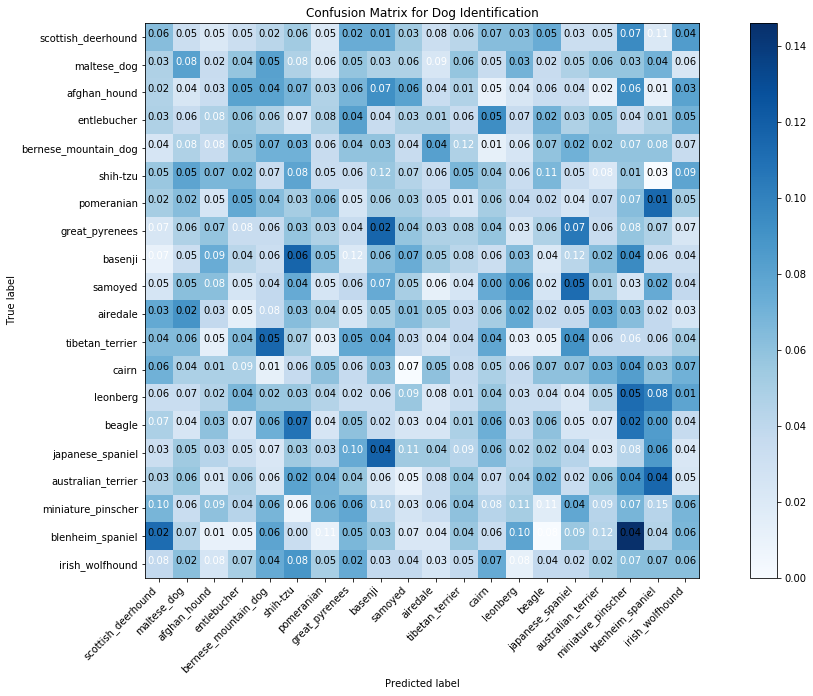

In [61]:
confusion_matrix_normalization(confusion, normalize=True)

Confusion matrix, without normalization
[[ 6  3  2  3  4  5  2  7  7  5  3  4  6  6  7  3  3  9  2  8]
 [ 4  7  3  5  7  4  2  5  4  4  2  5  3  6  3  4  5  5  6  2]
 [ 4  2  3  7  7  6  4  6  8  7  3  4  1  2  3  3  1  8  1  7]
 [ 4  3  4  5  4  2  4  7  3  4  4  3  8  3  6  4  5  3  4  6]
 [ 2  4  3  5  6  6  3  5  5  3  7  4  1  2  5  6  5  5  5  3]
 [ 5  7  6  6  3  7  3  3  5  4  3  6  5  3  6  3  2  5  0  7]
 [ 4  5  2  6  5  4  5  2  4  4  3  2  4  3  3  2  3  5  9  4]
 [ 2  4  5  3  3  5  4  3 10  5  4  4  5  2  4  9  3  5  4  2]
 [ 1  3  7  4  3 11  6  2  6  7  5  4  3  6  2  4  6  9  3  3]
 [ 2  5  5  2  3  6  2  3  6  4  1  2  6  7  2  9  4  2  6  3]
 [ 6  7  3  1  3  5  4  2  4  5  4  3  4  6  3  3  6  5  3  2]
 [ 5  5  1  5  9  4  1  6  6  3  2  3  6  1  1  7  3  3  3  4]
 [ 6  4  4  4  1  3  5  3  5  0  5  3  4  3  5  5  6  7  5  6]
 [ 3  3  4  6  5  5  4  3  3  5  2  3  5  3  3  2  4 10  9  7]
 [ 4  2  5  2  6  9  2  5  3  2  2  4  6  3  5  2  2  9  7  3]
 [ 3  5  4  3  

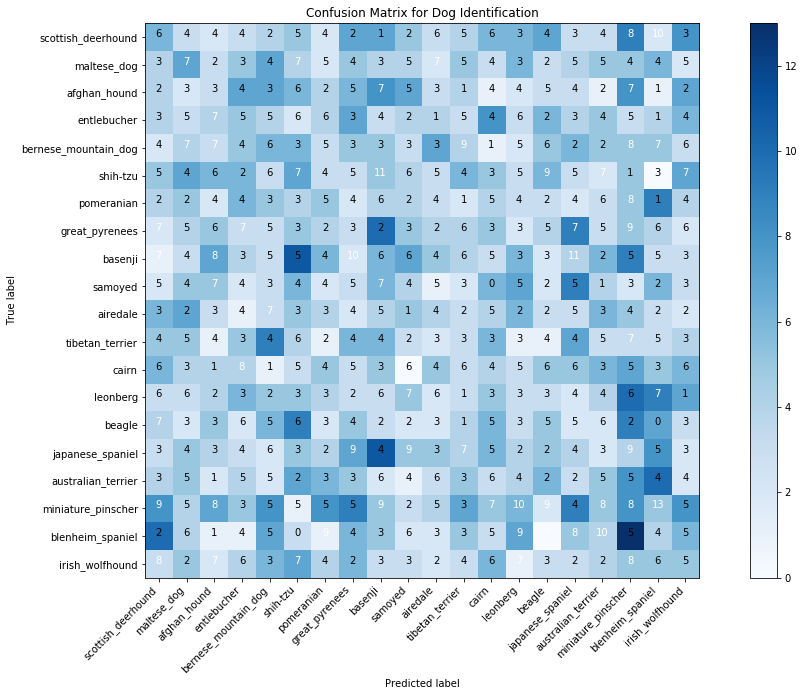

In [63]:
confusion=confusion_matrix(np.argmax(y_train,axis=1), np.argmax(predictions,axis=1))
confusion_matrix_normalization(confusion,normalize=False)

In [64]:
#Evaluating the Test Set
from keras.models import load_model
import math
from sklearn.preprocessing import OneHotEncoder
model = load_model('model_keras.h5')
predictions = model.predict_generator(testing_set)
# enc=OneHotEncoder(handle_unknown='ignore')
# X = [['scottish_deerhound',1],
#  ['maltese_dog',2],
#  ['afghan_hound',3],
#  ['entlebucher',4],
#  ['bernese_mountain_dog',5],
#  ['shih-tzu',6],
#  ['pomeranian',7],
#  ['great_pyrenees',8],
#  ['basenji',9],
#  ['samoyed',10],
#  ['airedale',11],
#  ['tibetan_terrier',12],
#  ['cairn',13],
#  ['leonberg',14],
#  ['beagle',15],
#  ['japanese_spaniel',16],
#  ['australian_terrier',17],
#  ['miniature_pinscher',18],
#  ['blenheim_spaniel',19],
#  ['irish_wolfhound',20]]
# enc.fit(X)

print(predictions)

[[3.67443706e-12 1.92409949e-04 2.23817498e-16 ... 1.48745483e-09
  3.56903368e-10 7.82577869e-16]
 [4.23275837e-04 2.23906408e-03 3.99174169e-05 ... 6.69516623e-03
  3.88673943e-05 5.43091971e-08]
 [3.77299580e-10 1.23358576e-20 4.02640540e-13 ... 4.18541691e-04
  1.15875540e-04 4.20502460e-08]
 ...
 [1.44247851e-24 8.01347643e-35 2.38617029e-23 ... 8.67287705e-18
  3.83669203e-07 4.03029592e-17]
 [2.57969259e-06 7.14343562e-09 3.64905606e-11 ... 3.01581191e-11
  1.51901128e-04 1.67468307e-03]
 [1.06787164e-04 4.91814353e-06 2.09328777e-09 ... 2.60893902e-08
  9.36748367e-03 1.92581660e-06]]


In [66]:
#Confusion matrix for multiclass classification
from sklearn.metrics import confusion_matrix
print(np.argmax(y_train,axis=1))
print(np.argmax(predictions,axis=1))
confusion = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1))
print('Confusion Matrix\n')
print(confusion)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy {:.2f}\n'.format(accuracy_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
top_20=['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'pomeranian',
 'great_pyrenees',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'cairn',
 'leonberg',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'miniature_pinscher',
 'blenheim_spaniel',
 'irish_wolfhound']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), target_names=top_20))

[17  9 12 ... 16 12  6]
[14 14 11  0  9 16  6 10 16 19  1  1 12 11  0 18  5  1  6  8 18  1  9  0
 18  9  2  7 13  1  4  8  7  9 15  4 10  9  8  7  3  0  7 13 18  3 11  8
 18 13  6  3  6 13  5  6 15  0 18  3 10 13  0 11 18  3  8 16  2 16 11 13
  0  5  3  7  0  3  9 11  5  4  1 15 19 12  9  3 16  7  9 19 10  2  6  6
 10 13  1 16 19  9 19  9  8 11 17 17  5 19 14  2  9  5  4 18  9  1  5 18
 14 19  3  1 11  2  6  2  7 12  0  9 10 15  6  3 12 13 10  5 17  1  5 13
  5  9 19  9  7  0  4 13 13  1 13 17 13 15 19 14  1 14 19 15 19 12 15 12
 13 19  9 14  5 11 15 10 13  8  9  2  3  5 10  1 18 17  3  6  9  6  1 16
 19 19 12  3 15  6  9 11  6  9  6  7  3  7  0 14 11  6 13 16  7 17 17  0
  4 11  5  5  3  9  9  4 15  4 12  9  4 12  1 14 11 16 11  7 12  5  0 10
 19  6 19  4 18 13 14  9  1  9 17  5 18 17  9  1 15 19  1 10  4  7  3 17
 10 18  1 12  1  3  5  1  4  0 10 18 18  1  7  7 15 11 11 13 19  1  2 16
  3 18  1 11  2 11 14 19 18 16  0  9  8  8  5  5  6  1  7 18  3 15 12 16
  8  3 12  0  0 16 18 15  4

Normalized confusion matrix
[[0.    0.238 0.    0.    0.048 0.048 0.143 0.095 0.048 0.    0.    0.
  0.048 0.048 0.    0.    0.095 0.    0.095 0.095]
 [0.048 0.    0.048 0.095 0.    0.095 0.095 0.048 0.048 0.143 0.    0.048
  0.    0.095 0.048 0.    0.048 0.048 0.    0.095]
 [0.    0.    0.067 0.    0.133 0.067 0.067 0.067 0.067 0.    0.    0.
  0.067 0.067 0.067 0.067 0.067 0.    0.2   0.   ]
 [0.    0.042 0.042 0.    0.083 0.042 0.125 0.083 0.    0.    0.083 0.083
  0.083 0.042 0.083 0.    0.042 0.042 0.042 0.083]
 [0.15  0.    0.    0.1   0.    0.05  0.    0.1   0.    0.    0.1   0.1
  0.05  0.1   0.    0.05  0.05  0.05  0.05  0.05 ]
 [0.08  0.04  0.04  0.12  0.04  0.04  0.    0.12  0.    0.    0.08  0.12
  0.    0.04  0.    0.04  0.08  0.12  0.04  0.   ]
 [0.087 0.13  0.    0.087 0.    0.043 0.    0.043 0.    0.    0.043 0.174
  0.043 0.13  0.043 0.043 0.043 0.    0.    0.087]
 [0.1   0.05  0.    0.15  0.05  0.05  0.1   0.    0.1   0.15  0.    0.15
  0.    0.    0.    0.    0.    0

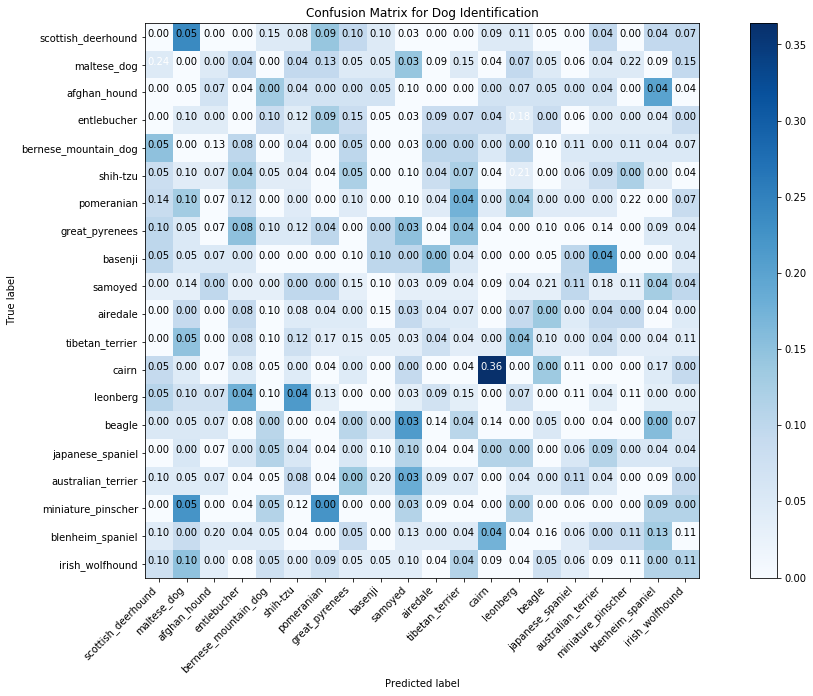

In [67]:
confusion_matrix_normalization(confusion, normalize=True)

Confusion matrix, without normalization
[[0 5 0 0 1 1 3 2 1 0 0 0 1 1 0 0 2 0 2 2]
 [1 0 1 2 0 2 2 1 1 3 0 1 0 2 1 0 1 1 0 2]
 [0 0 1 0 2 1 1 1 1 0 0 0 1 1 1 1 1 0 3 0]
 [0 1 1 0 2 1 3 2 0 0 2 2 2 1 2 0 1 1 1 2]
 [3 0 0 2 0 1 0 2 0 0 2 2 1 2 0 1 1 1 1 1]
 [2 1 1 3 1 1 0 3 0 0 2 3 0 1 0 1 2 3 1 0]
 [2 3 0 2 0 1 0 1 0 0 1 4 1 3 1 1 1 0 0 2]
 [2 1 0 3 1 1 2 0 2 3 0 3 0 0 0 0 0 0 1 1]
 [2 1 1 1 0 0 0 0 2 2 3 1 0 0 0 2 4 0 0 1]
 [1 1 3 1 1 3 3 1 0 1 1 1 0 1 1 3 1 1 4 3]
 [0 2 0 2 0 1 1 1 0 2 1 1 0 2 3 1 2 2 0 1]
 [0 4 0 2 0 2 1 1 1 1 2 1 1 4 1 1 2 1 1 1]
 [2 1 0 1 0 1 0 1 0 2 0 0 8 0 3 0 0 0 1 2]
 [3 2 2 5 0 6 1 0 0 1 2 1 0 2 0 0 1 0 1 1]
 [1 1 1 0 2 0 0 2 1 4 0 2 0 0 1 0 0 0 3 1]
 [0 1 0 1 2 1 0 1 0 2 0 0 2 2 0 1 2 1 1 1]
 [1 1 1 0 0 2 0 3 1 4 1 1 0 1 1 2 1 0 0 2]
 [0 2 0 0 1 0 2 0 0 1 0 0 0 1 0 0 0 0 1 1]
 [1 2 1 1 1 0 0 2 0 1 1 1 4 0 0 1 2 2 3 0]
 [2 4 1 0 2 1 2 1 1 1 0 3 0 0 2 1 0 0 3 3]]


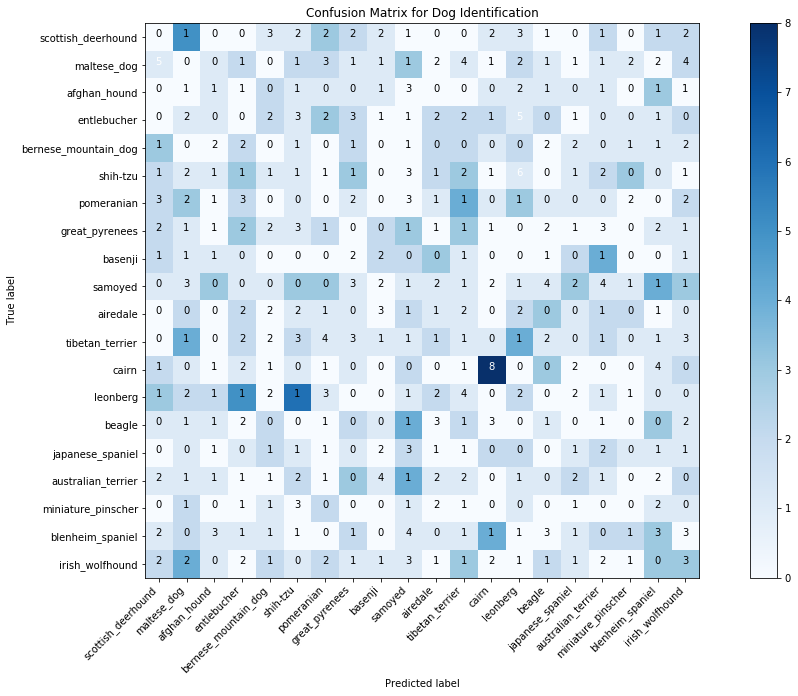

In [68]:
confusion=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions, axis=1))
confusion_matrix_normalization(confusion, normalize=False)

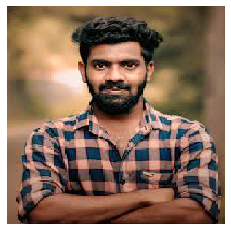

miniature_pinscher
0.6193081140518188


In [4]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify
input_shape=(299,299,3)

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('man.jpg', target_size=input_shape)
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n{max(pred)[sorted_breeds_list.index(predicted_class)]}")

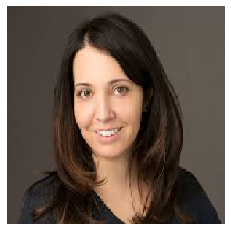

miniature_pinscher

0.693259298801422119


In [5]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('woman.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

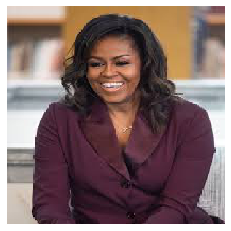

shih-tzu

0.228455662727355957


In [9]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('woman1.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

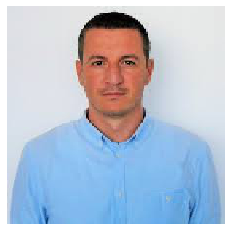

beagle

0.563098669052124023


In [7]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('man1.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

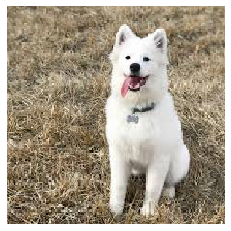

samoyed

0.887676894664764404


In [11]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('samoyed.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

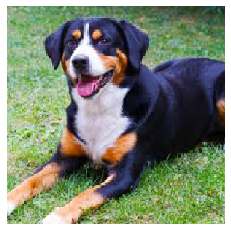

entlebucher

0.986304342746734619


In [12]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('C:/Users/win10/Documents/pati/Licenta/WebApplication/uploads/entlebutcher.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

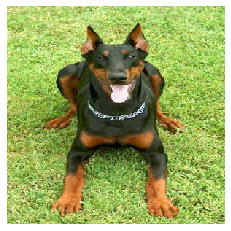

basenji

0.998693406581878662


In [13]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('C:/Users/win10/Documents/pati/Licenta/WebApplication/uploads/doberman.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

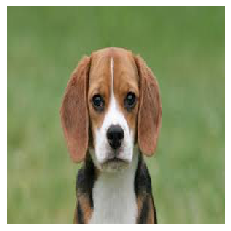

entlebucher

0.524308145046234131


In [14]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('C:/Users/win10/Documents/pati/Licenta/WebApplication/uploads/biggle.jpg', target_size=(299, 299, 3))
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

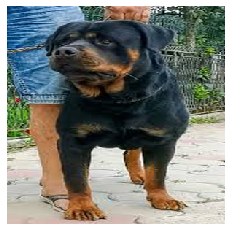

leonberg

0.659366965293884277


In [3]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('rottweiler.jpg')
img = img.resize((299,299),Image.ANTIALIAS)
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

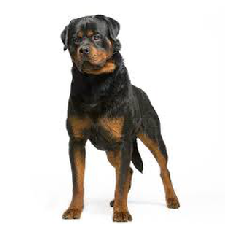

miniature_pinscher

0.775495171546936035


In [4]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('rottweiler1.jpg')
img = img.resize((299,299),Image.ANTIALIAS)
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))

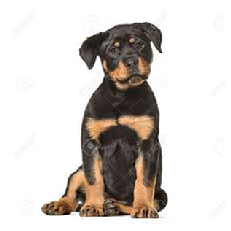

miniature_pinscher

0.998033583164215088


In [5]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import numpy as np
import pandas as pd

#constants
num_classes = 20 # the number of breeds we want to classify

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('C:/Users/win10/Documents/pati/Licenta/dog-breed-identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)

model = load_model('model_keras.h5')

img = image.load_img('rottweiler2.jpg')
img = img.resize((299,299),Image.ANTIALIAS)
img_tensor = image.img_to_array(img)                    # (height, width, channels)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

pred = model.predict(img_tensor)
sorted_breeds_list = sorted(selected_breed_list)
predicted_class = sorted_breeds_list[np.argmax(pred)]

plt.imshow(img_tensor[0])                           
plt.axis('off')
plt.show()

print(f"{predicted_class}\n")
print("{:.18f}".format(max(pred)[sorted_breeds_list.index(predicted_class)]))